### Loading Required Packages

In [1]:
import pandas as pd
import nltk
from nltk.corpus import stopwords
from nltk import word_tokenize, sent_tokenize
from nltk import PorterStemmer
from nltk.stem import WordNetLemmatizer
import re
stop_words = set(stopwords.words('english'))
import numpy as np
import spacy
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import warnings
warnings.filterwarnings('ignore')

### loading and Reading Datasets

In [3]:
data = pd.read_csv('D://MSBA//Third Sem//NLP//group Project//archive (6)//spam_ham_dataset.csv')

In [4]:
data.head()

,Unnamed: 0,label,text,label_num
0,605,ham,Subject: enron methanol ; meter # : 988291\r\n...,0
1,2349,ham,"Subject: hpl nom for january 9 , 2001\r\n( see...",0
2,3624,ham,"Subject: neon retreat\r\nho ho ho , we ' re ar...",0
3,4685,spam,"Subject: photoshop , windows , office . cheap ...",1
4,2030,ham,Subject: re : indian springs\r\nthis deal is t...,0


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5171 entries, 0 to 5170
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  5171 non-null   int64 
 1   label       5171 non-null   object
 2   text        5171 non-null   object
 3   label_num   5171 non-null   int64 
dtypes: int64(2), object(2)
memory usage: 161.7+ KB


##### Keep only email (text) data from the dataframe

In [6]:
data = data.drop(columns = ["label", "label_num", "Unnamed: 0"], axis = 1)

In [7]:

data = data.text.values

In [8]:
type(data[0])
    

str

### Data Pre-Processing 

In [9]:
len(data)

5171

In [10]:
def preprocessing (text):

    wnl = nltk.stem.WordNetLemmatizer()
    text = text.lower()
    text = re.sub("(http|https|www)(:|\.)\S+.com"," ",text)
    text = re.sub('[^a-zA-Z0-9\n]', ' ', text)
    text = re.sub("[^\w\d]"," ",text)
    text = re.sub("\d+"," ",text)
    text = re.sub('\s+',' ', text)
    text = " ".join([wnl.lemmatize(word.lower()) for word in text.split() if word.lower() not in nltk.corpus.stopwords.words("english")])
    return text


In [11]:
preprocessing(data[0])

'subject enron methanol meter follow note gave monday preliminary flow data provided daren please override pop daily volume presently zero reflect daily activity obtain gas control change needed asap economics purpose'

In [12]:
processed_email = [preprocessing(email) for email in data]

In [13]:
processed_email[4]

'subject indian spring deal book teco pvr revenue understanding teco sends u check received answer whether predermined price associated deal teco let u know giving continue chase deal need'

### Data Exploration

In this section, we will build the word cloud to visualize most common words in the corpus, so that we can get some insight, whether such common words are really important.

### Creating Wordcloud

In [14]:
#pip install wordcloud

In [15]:
import wordcloud
from wordcloud import WordCloud

In [16]:
wordcloud = WordCloud(background_color = "white", max_words=300, contour_width = 10, contour_color ='steelblack', relative_scaling = 1)

In [17]:
all_email_text = ",".join(processed_email)

In [18]:
wordcloud.generate(all_email_text)

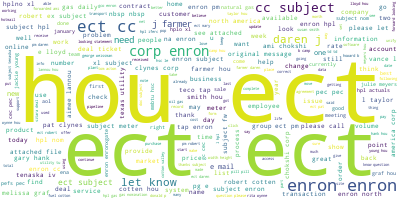

In [19]:
wordcloud.to_image()

from this initial wordcloud, we can see that most common words are infact nonstandard english words and also common words like subject, email, attach etc. are less important in this analysis. 

##### Remove 50 most common words, the words that are less than or equal to three characters and the words such as people names, months etc.

In [20]:
words = []
for i in processed_email:
    for word in nltk.word_tokenize(i):
        words.append(word)

In [21]:
len(set(words))

43185

In [22]:
fd = nltk.FreqDist(word for word in words )
common_words = [w for (w,c) in fd.most_common(50)]
short_words = [w for(w,c) in fd.most_common() if len(w) <= 3]


In [23]:
namelist = [name.lower() for name in nltk.corpus.names.words()]


In [24]:
day_month = ['sunday', 'monday','tuesday', 'wednesday', 'thursday', 'friday', 
             'saturday', 'january', 'february', 'march', 'april', 'may', 'june', 
             'july', 'august', 'september', 'october', 'november', 'december']

In [25]:
extra_common = ['well', 'said', 'sent', 'also']

In [26]:
stopwords_extra = common_words+short_words+namelist+day_month+extra_common
#stopwords_extra

In [27]:
def preprocessing_2 (text):
    text = " ".join([t.lower() for t in text.split() if t not in stopwords_extra]) 
    return text        

In [28]:
preprocessing_2(processed_email[100])

'help talk getting labor distribution report employee hitting discussed prior soem manager receiving monthly report help thank'

In [29]:
#processed_email_1 = []
#for email in processed_email:
    #processed_email_1.append(preprocessing_2(email))

In [30]:
processed_email_1 = [preprocessing_2(email) for email in processed_email]

In [31]:
all_email_text_1 = ",".join(processed_email_1)

In [32]:
wordcloud.generate(all_email_text_1)

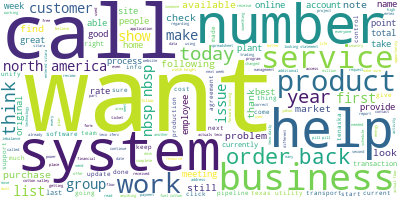

In [33]:
wordcloud.to_image()

In [34]:
#### check if there are words that starts with uppercase

uppercase = []
for email in processed_email_1:
    for word in email.split():
        if re.search('^[A-Z]', word):
            uppercase.append(word)
        
uppercase


[]

## Topic Modeling using Latent Dirichlet Allocation

##### Load Gensim packages 

In [35]:
import gensim
from gensim.utils import simple_preprocess
import gensim.corpora as corpora

##### Convert all emails to the list of list of tokens

In [36]:
def sent_to_words(sentences):
    for sentences in sentences:
        yield(gensim.utils.simple_preprocess(str(sentences)))
        

In [37]:
data = processed_email_1

In [38]:
data_words = list(sent_to_words(data))
data_words[:1]



[['methanol',
  'follow',
  'note',
  'gave',
  'preliminary',
  'flow',
  'data',
  'provided',
  'override',
  'daily',
  'presently',
  'zero',
  'reflect',
  'daily',
  'activity',
  'obtain',
  'control',
  'needed',
  'asap',
  'economics',
  'purpose']]

In [39]:
#print(data_words)

##### Create Dictionary 

This dictionary is the key(index) and value of all the words of the processed emails.  

In [40]:
corpus_dict = corpora.Dictionary (data_words)
print(corpus_dict)


Dictionary(37498 unique tokens: ['activity', 'asap', 'control', 'daily', 'data']...)


##### Create Document Term Matrix

In [41]:
emails = data_words

In [42]:
doc_term_matrix = [corpus_dict.doc2bow(email) for email in emails] 

In [43]:
print(doc_term_matrix[:][1000])

[(0, 1), (10, 2), (79, 1), (83, 1), (107, 1), (128, 1), (157, 1), (188, 1), (191, 1), (217, 1), (255, 1), (268, 1), (285, 1), (350, 1), (352, 1), (420, 1), (421, 1), (425, 1), (449, 1), (454, 1), (495, 1), (510, 1), (536, 1), (600, 1), (770, 2), (861, 1), (899, 1), (932, 1), (974, 1), (1011, 3), (1048, 2), (1089, 1), (1105, 1), (1145, 1), (1171, 1), (1243, 1), (1254, 1), (1294, 1), (1338, 1), (1414, 1), (1662, 1), (1672, 1), (2081, 2), (2194, 2), (2201, 1), (2247, 1), (2325, 2), (2612, 1), (2869, 1), (2986, 1), (3496, 1), (3924, 2), (3926, 1), (4096, 1), (4426, 1), (4669, 3), (6419, 1), (6614, 1), (7144, 1), (9372, 1)]


### LDA Model Training 

In [44]:
from pprint import pprint


In [45]:
Lda = gensim.models.ldamodel.LdaModel


In [46]:
ldamodel = Lda(doc_term_matrix, num_topics =8, id2word = corpus_dict, passes = 20, random_state = 0, eval_every = None)


In [47]:
ldamodel.print_topics()


[(0,
  '0.012*"flow" + 0.012*"ticket" + 0.008*"sitara" + 0.008*"nomination" + 0.007*"file" + 0.007*"production" + 0.006*"back" + 0.006*"issue" + 0.006*"allocation" + 0.005*"could"'),
 (1,
  '0.018*"pill" + 0.011*"file" + 0.009*"hplno" + 0.008*"viagra" + 0.007*"prescription" + 0.007*"cialis" + 0.006*"drug" + 0.006*"online" + 0.006*"best" + 0.006*"chokshi"'),
 (2,
  '0.006*"tenaska" + 0.005*"rate" + 0.005*"desk" + 0.005*"call" + 0.005*"texas" + 0.004*"transport" + 0.004*"group" + 0.004*"system" + 0.004*"report" + 0.004*"meeting"'),
 (3,
  '0.013*"nomination" + 0.011*"fuel" + 0.011*"contact" + 0.010*"eastrans" + 0.010*"computron" + 0.008*"effective" + 0.007*"pefs" + 0.006*"valley" + 0.006*"cotton" + 0.006*"free"'),
 (4,
  '0.006*"order" + 0.006*"click" + 0.005*"account" + 0.005*"free" + 0.005*"address" + 0.005*"number" + 0.005*"window" + 0.004*"name" + 0.004*"site" + 0.004*"service"'),
 (5,
  '0.021*"font" + 0.015*"height" + 0.014*"nbsp" + 0.012*"size" + 0.011*"width" + 0.008*"align" + 0.

#### Topic Coherence

In [48]:
from gensim.models import CoherenceModel

coherence_model_lda = CoherenceModel(model =ldamodel, texts = emails, dictionary = corpus_dict, coherence = 'c_v')
coherence_lda = coherence_model_lda.get_coherence()

In [49]:
print('\nCoherence Score: ', coherence_lda)


Coherence Score:  0.5135197792237558


### Model improvement 

In [50]:
def compute_coherence_values(dictionary, corpus, text, limit, start = 2, step = 1):
    
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = Lda(corpus= doc_term_matrix, num_topics = num_topics, random_state = 42,
                   passes = 10, per_word_topics = True, id2word =dictionary)
        
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts = emails, dictionary= corpus_dict, coherence = 'c_v')
        coherence_values.append(coherencemodel.get_coherence())
    
    return model_list, coherence_values

In [51]:
model_list, coherence_values = compute_coherence_values(dictionary = corpus_dict, corpus = doc_term_matrix, text = emails, start = 2, limit = 15, step = 1)

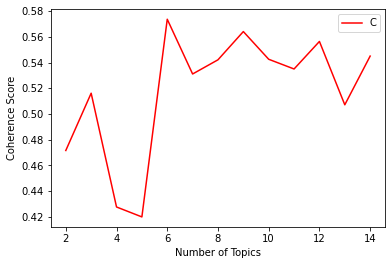

In [52]:
limit = 15; start = 2; step = 1 
x = range(start, limit, step)
plt.plot(x, coherence_values, color = 'red')
plt.xlabel("Number of Topics")
plt.ylabel("Coherence Score")
plt.legend (("Coherence_values"), loc = 'best')
plt.show()

In [53]:
#lda_model = gensim.models.LdaMulticore(corpus = corpus, 
                                      #id2word = corpus_dict, num_topics = 6)

In [54]:
ldamodel_improved = Lda(doc_term_matrix, num_topics = 6, id2word = corpus_dict, passes = 20, random_state = 42, eval_every = None)


In [55]:
ldamodel_improved.print_topics()


[(0,
  '0.008*"statement" + 0.007*"stock" + 0.006*"business" + 0.006*"security" + 0.006*"report" + 0.006*"service" + 0.005*"investment" + 0.005*"within" + 0.005*"market" + 0.004*"product"'),
 (1,
  '0.029*"font" + 0.021*"height" + 0.019*"nbsp" + 0.015*"width" + 0.015*"size" + 0.011*"align" + 0.009*"style" + 0.009*"href" + 0.009*"border" + 0.009*"color"'),
 (2,
  '0.013*"eastrans" + 0.010*"nomination" + 0.010*"effective" + 0.009*"pefs" + 0.008*"valley" + 0.007*"fuel" + 0.007*"cotton" + 0.007*"redeliveries" + 0.006*"delivery" + 0.005*"aepin"'),
 (3,
  '0.014*"teco" + 0.008*"actuals" + 0.006*"utility" + 0.006*"noms" + 0.006*"texas" + 0.006*"iferc" + 0.005*"chokshi" + 0.005*"flow" + 0.005*"actual" + 0.004*"daily"'),
 (4,
  '0.008*"sitara" + 0.008*"ticket" + 0.006*"production" + 0.006*"energy" + 0.005*"flow" + 0.005*"call" + 0.005*"texas" + 0.004*"following" + 0.004*"issue" + 0.004*"plant"'),
 (5,
  '0.005*"order" + 0.005*"free" + 0.005*"click" + 0.005*"pill" + 0.004*"contact" + 0.004*"prod

#### Improved model topic coherence score 

In [57]:
coherence_model_lda_imp = CoherenceModel(model = ldamodel_improved, texts = emails, dictionary = corpus_dict, coherence ='c_v')
coherence_lda_improved = coherence_model_lda_imp.get_coherence()
print('\nCoherence Score: ', coherence_lda_improved)


Coherence Score:  0.5832239657616967


#### Load Visualization Packages

In [58]:

import pickle
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
import matplotlib.pyplot as plt

%matplotlib inline


In [59]:
pyLDAvis.enable_notebook()

In [60]:
vis = gensimvis.prepare(ldamodel_improved, doc_term_matrix, corpus_dict, mds = "mmds")
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
4     -0.253253  0.118537       1        1  32.441384
5     -0.056325 -0.251186       2        1  26.278232
0     -0.241205 -0.122614       3        1  21.587812
3      0.098792  0.306014       4        1   9.423773
1      0.257320 -0.134522       5        1   5.291606
2      0.194671  0.083772       6        1   4.977193, topic_info=             Term        Freq       Total Category  logprob  loglift
6564         font  459.000000  459.000000  Default  30.0000  30.0000
355    nomination  653.000000  653.000000  Default  29.0000  29.0000
13657      height  332.000000  332.000000  Default  28.0000  28.0000
187          teco  400.000000  400.000000  Default  27.0000  27.0000
3363         nbsp  307.000000  307.000000  Default  26.0000  26.0000
...           ...         ...         ...      ...      ...      ...
368     agreement   45.976254  405.155899   Topic6  -5.7795   0.8242
1928      hotmail   32.798750   97.958868   Topic6  -6.1172   1.9061
2863     beaumont   32.642179  121.406347   Topic6  -6.1220   1.6868
2866        mobil   29.393147  100.398825   Topic6  -6.2268   1.7719
59      following   29.281908  566.310434   Topic6  -6.2306   0.0381

[366 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
1095      1  0.172848   account
1095      2  0.794543   account
1095      3  0.022303   account
1095      6  0.008364   account
0         1  0.847073  activity
...     ...       ...       ...
1338      6  0.015357      work
133       1  0.233618      year
133       2  0.316446      year
133       3  0.443873      year
133       6  0.006371      year

[662 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[5, 6, 1, 4, 2, 3])

## Topic distribution 

##### Distributions of topic of document (each email)

In [61]:
doc = []
count = 0
for i in ldamodel_improved[doc_term_matrix]:
    count += 1
    doc.append( ("doc:", count, i))
doc[0:8]

[('doc:', 1, [(1, 0.06097791), (4, 0.9085699)]),
 ('doc:',
  2,
  [(0, 0.041862093),
   (1, 0.041915573),
   (2, 0.041675266),
   (3, 0.041834958),
   (4, 0.79101706),
   (5, 0.04169504)]),
 ('doc:', 3, [(0, 0.25040838), (4, 0.26119196), (5, 0.48514554)]),
 ('doc:', 4, [(0, 0.10269402), (1, 0.88109004)]),
 ('doc:', 5, [(3, 0.17767936), (4, 0.7848273)]),
 ('doc:', 6, [(0, 0.09521216), (4, 0.088269316), (5, 0.7956454)]),
 ('doc:', 7, [(0, 0.05014883), (5, 0.94569707)]),
 ('doc:', 8, [(0, 0.047142554), (2, 0.023971478), (5, 0.92062646)])]

In [62]:
def format_topics_sentences (ldamodel = None, corpus = doc_term_matrix, texts = emails):
    sent_topics_df = pd.DataFrame()
    
    for i, row_list in enumerate(ldamodel_improved[doc_term_matrix]):
        row = row_list[0] if ldamodel_improved.per_word_topics else row_list
        row = sorted(row, key = lambda x:(x[1]), reverse = True)
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:
                wp = ldamodel_improved.show_topic(topic_num)
                topic_key_words = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic, 4),
                                                                  topic_key_words]), ignore_index = True)
            else:
                break
    sent_topics_df.columns =['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']
    
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis = 1)
    return(sent_topics_df)

In [63]:
df_topic_sents_keywords = format_topics_sentences(ldamodel = ldamodel_improved, corpus = doc_term_matrix, texts = emails)
df_topic_sents_keywords

,Dominant_Topic,Perc_Contribution,Topic_Keywords,0
0,4,0.9086,"sitara, ticket, production, energy, flow, call...","[methanol, follow, note, gave, preliminary, fl..."
1,4,0.7910,"sitara, ticket, production, energy, flow, call...","[file, hplnol, hplnol]"
2,5,0.4851,"order, free, click, pill, contact, product, of...","[neon, retreat, around, wonderful, year, neon,..."
3,1,0.8811,"font, height, nbsp, width, size, align, style,...","[photoshop, window, office, cheap, main, trend..."
4,4,0.7848,"sitara, ticket, production, energy, flow, call...","[indian, spring, book, teco, revenue, understa..."
...,...,...,...,...
5166,3,0.6365,"teco, actuals, utility, noms, texas, iferc, ch...","[transport, decreased, chokshi, edmondson, rel..."
5167,2,0.8585,"eastrans, nomination, effective, pefs, valley,...","[following, noms, take, extra, mmcf, weekend, ..."
5168,4,0.4953,"sitara, ticket, production, energy, flow, call...","[calpine, daily, nomination, mention, earlier,..."
5169,4,0.8378,"sitara, ticket, production, energy, flow, call...","[industrial, worksheet, activity, worksheet, a..."


In [64]:
df_topic_distribution = df_topic_sents_keywords['Dominant_Topic'].value_counts().reset_index(name = "num Documents")
df_topic_distribution.columns = ['Dominant_Topic', 'Num Documents']
df_topic_distribution.sort_values("Dominant_Topic")


,Dominant_Topic,Num Documents
2,0,526
4,1,246
5,2,219
3,3,470
0,4,2398
1,5,1312


### Visualize Topics - in WordCloud 

In [66]:
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt

In [67]:
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]


In [68]:
cloud = WordCloud(stopwords = stop_words, 
                 background_color = 'white', 
                 width = 2500,
                 height = 2800,
                 max_words = 20, 
                 colormap = 'tab10',
                 color_func = lambda *args, **kwargs :cols[i],
                 prefer_horizontal = 1.0)

In [69]:
topics = ldamodel_improved.show_topics(formatted = False)


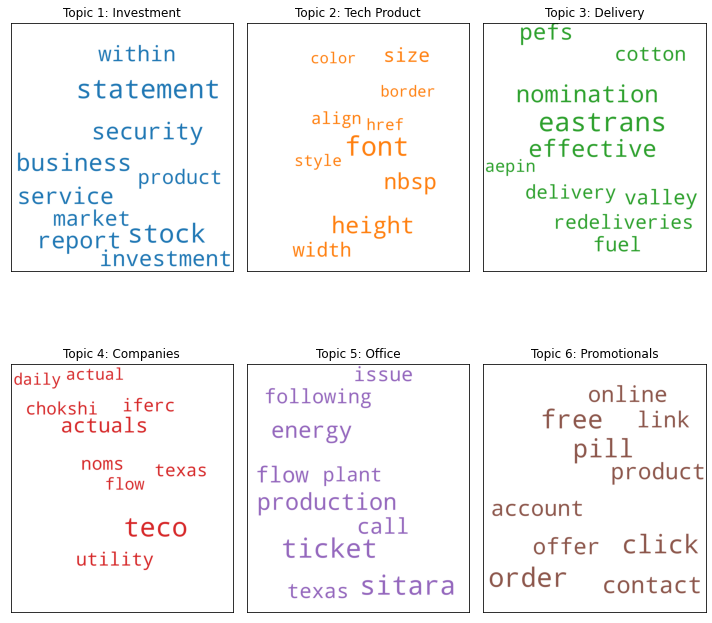

In [70]:
fig, axes = plt.subplots(2,3, figsize =(10,10))
#my_topics = ['Investment', 'Tech-Product', 'Delivery', 'Companies', 'Office', 'Promotionals']
for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size = 300)
    plt.gca().imshow(cloud)
    #plt.gca().set_title('Topic ' + str([i]), fontdict = dict(size= 15))
    #plt.gca().set_title(str([topic for topic in my_topics]), fontdict = dict(size = 20))
    plt.gca().axis('on')
    #for xlabel_i in plt.gca().axes.get_xticklabels():
        #xlabel_i.set_visible(False)
axes[0,0].set_title('Topic 1: Investment')
axes[0,1].set_title('Topic 2: Tech Product')
axes[0,2].set_title('Topic 3: Delivery')
axes[1,0].set_title('Topic 4: Companies')
axes[1,1].set_title('Topic 5: Office')
axes[1,2].set_title('Topic 6: Promotionals')
plt.subplots_adjust(wspace = 2, hspace = 2)
for ax in axes.flat:
    ax.axes.yaxis.set_visible(False)
    ax.axes.xaxis.set_visible(False)

#plt.axis('off')
plt.margins(x=0.2, y=0.22)
plt.tight_layout()
for ax in axes.flat:
    ax.label_outer()
plt.show()

## CountVectorizer Implementation from scikit-learn 

In [71]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from nltk import ne_chunk
stop_words = set(nltk.corpus.stopwords.words('english'))

In [72]:
vect = TfidfVectorizer(stop_words = stop_words, max_features = 1000)

In [73]:
vect_text = vect.fit_transform(processed_email_1)

In [74]:
print(vect_text.shape)

(5171, 1000)


In [76]:
idf = vect.idf_

In [77]:
dd = dict(zip(vect.get_feature_names(), idf))
l = sorted(dd, key = (dd).get)

In [ ]:
print(l[0], l[-1])

In [78]:
from sklearn.decomposition import LatentDirichletAllocation 

In [79]:
lda_model = LatentDirichletAllocation(n_components = 6, learning_method = 'online', random_state = 0, max_iter =20)

In [80]:
lda_top = lda_model.fit_transform(vect_text)

In [81]:
print(lda_top.shape)

(5171, 6)


In [82]:
vocab = vect.get_feature_names()

for i, comp in enumerate(lda_model.components_):
    vocab_comp = zip(vocab, comp)
    sorted_words = sorted(vocab_comp, key= lambda x:x[1], reverse=True)[:10]
    print("Topic "+str(i)+": ")
    for t in sorted_words:
        print(t[0],end=" ")
    print("\n")

Topic 0: 
sitara ticket flow production energy plant call purchase delivery following 

Topic 1: 
chokshi lannou reliantenergy noms file rolex pain watch want tejas 

Topic 2: 
hplno tenaska revised file revision demand effective nomination cleburne spreadsheet 

Topic 3: 
click hplnl online eastrans best order nomination free want like 

Topic 4: 
teco actuals iferc daily utility actual flow texas neon jones 

Topic 5: 
file hplo mobil beaumont methanol noms nomination natural sept load 

